Проект №5.


# Компьютер говорит НЕТ

## Описание задачи
Построить модель банковского скоринга. По имеющимся данным клиента (информация из анкетных данных заемщиков и факт наличия дефолта) необходимо определить, стоит ли ему выдавать кредит. Флаг default = 1, если кредит лучше не выдавать, = 0, если можно выдать.

## Описание полей

* client_id - идентификатор клиента

* education - уровень образования
 
* sex - пол заемщика
 
* age - возраст заемщика
 
* car - флаг наличия автомобиля
 
* car_type - флаг автомобиля иномарки
 
* decline_app_cnt - количество отказанных прошлых заявок
 
* good_work - флаг наличия “хорошей” работы
 
* bki_request_cnt - количество запросов в БКИ
 
* home_address - категоризатор домашнего адреса
 
* work_address - категоризатор рабочего адреса
 
* income - доход заемщика
 
* foreign_passport - наличие загранпаспорта
 
* sna - связь заемщика с клиентами банка
 
* first_time - давность наличия информации о заемщике

* score_bki - скоринговый балл по данным из БКИ
 
* region_rating - рейтинг региона
 
* app_date - дата подачи заявки
 
* default - флаг дефолта по кредиту

## Этапы работы.
1. Сделать общий краткий анализ датасета
2. Разделить признаки по типу данных
3. Очистка данных. Обработка пропусков, подготовка данных к обработке.
4. Анализ корреляции. Удаление лишних признаков, добавление новых.
5. Выбор модели. Настройка.
6. Пробуем.[](http://)


# Загрузка библиотек и файлов

In [1]:
from pandas import Series
import pandas as pd
import numpy as np
import math

from datetime import date
from datetime import datetime, timedelta
import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


Установим константы для воспроизводимости эксперимента

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

TEST_SIZE = 0.2
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

* df_train - тренировочные данные. Целевая переменная известна
* df_test - проверочные данные без целевой переменной

In [3]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')
display(df_train.head(3))
display(df_test.head(3))
display(sample_submission.head(3))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y


,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370


Объединим эти датасеты, так как признаки нужно обработать одинаково. Чтобы их различать создадим флаг *train*

In [4]:
df_train['train'] = 1 # пометим тренировочные
df_test['train'] = 0 # пометим тестовые
df = pd.concat([df_train, df_test], ignore_index=True)
print('Размер df_train:', df_train.shape)
display(df.head(3))
print('Размер df_test:', df_test.shape)
display(df.tail(3))


Размер df_train: (73799, 20)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1


Размер df_test: (36349, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,NaN,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,NaN,0
110147,69044,17MAR2014,SCH,M,38,N,N,0,0,-1.507549,2,50,1,2,15000,4,2,N,NaN,0


Найдем пропуски и их количество в данных, заполним/удалим их

In [5]:
df.isnull().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

Пропуски есть только в признаке Education. Рассмотрим признак поподробнее, а затем и остальные признаки изучм более детально

## Education

<AxesSubplot:xlabel='education', ylabel='count'>

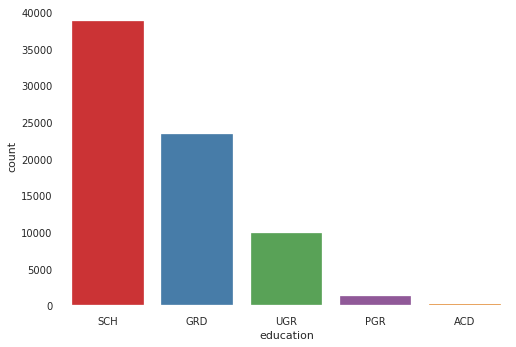

In [6]:
mode = df['education'].mode().item() # найдем наиболее часто встречающийся вид образования в датасете#
sns.countplot(df_train['education'],palette="Set1")  #подтвердим графиком

Заменим пустые значения в *education* самыми частыми. 

Пробовали ставить слово 'unknown', но метрики ухудшились

In [7]:
df['education'] = df['education'].fillna(mode)

Преобразуемуем в числовое значение данный столбец

In [8]:
label_encoder = LabelEncoder()

df['education'] = label_encoder.fit_transform(df['education'])
print(dict(enumerate(label_encoder.classes_)))
df.sample(3)

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
46870,52048,28FEB2014,1,M,27,Y,N,0,0,-1.696550,1,40,1,3,25000,3,3,N,0.0,1
35827,26691,03FEB2014,3,F,35,N,N,0,0,-2.667342,0,50,2,3,30000,1,3,N,0.0,1
75422,28169,04FEB2014,3,F,34,Y,N,0,0,-2.057099,0,50,2,2,15000,1,4,N,NaN,0


In [9]:
# df.drop(['client_id'], 1, inplace=True)

In [10]:
df.isnull().sum()

client_id               0
app_date                0
education               0
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

## APP_DATE
Обработка признака, получение новых числовых признаков на его основе

In [11]:
df['app_date'] = pd.to_datetime(df['app_date']) # - преобразуем в нормальный вид столбец с датой подачи
df = df.sort_values(by='app_date')

Посмотрим количство заявок по датам

<AxesSubplot:xlabel='app_date', ylabel='count'>

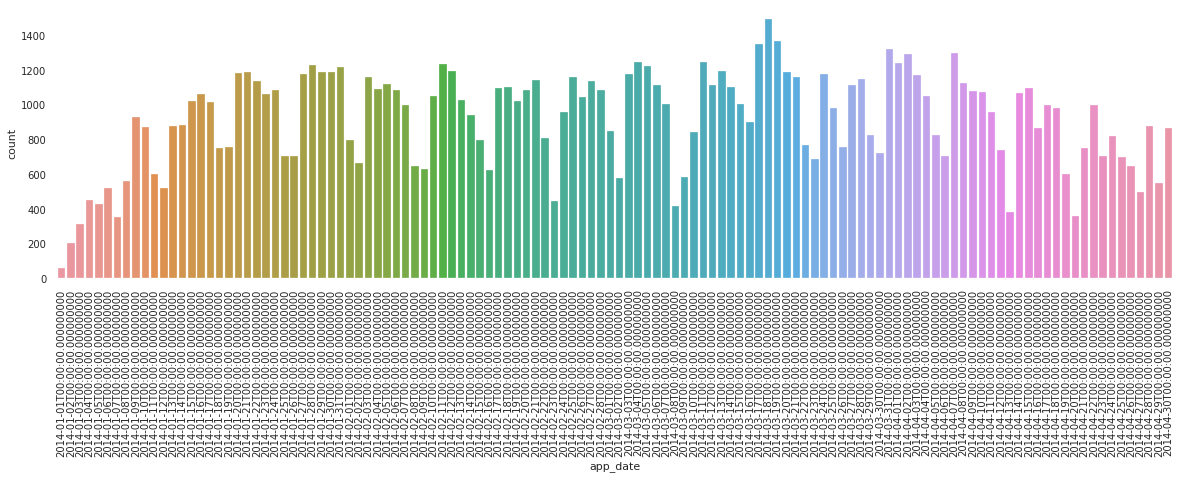

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(20,5))
plt.xticks(rotation=90)
# plt.xticks(rotation=90, ['jan','feb','mar','apr'])
sns.countplot(x='app_date', data=df, orient='v')

Из чего сделаем выводы:
* данные взяты на отрезке времени с января 2014 по апрель 2014
* количество заявок зависит от дня недели и от новогодних праздников

Сделаем новые признаки:
- *weekday_app* - день недели, в который происходила подачи заявки (0-пн, 1-вт, 2-ср...)
- *day_app* - Еще один признак - количество дней с начала записи данных до каждой конкретной подачи 

In [13]:
idx = df.columns.get_loc('app_date') 
df.insert(loc=idx+1, column='weekday_app', value= df['app_date'].dt.dayofweek)
df.insert(loc=idx+1, column='day_app', value= (df['app_date'] - df['app_date'].min()).dt.days.astype(int))
df.head()

,client_id,app_date,day_app,weekday_app,education,sex,age,car,car_type,decline_app_cnt,...,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
11038,42,2014-01-01,0,2,4,F,47,Y,N,0,...,1,60,2,3,35000,1,4,Y,0.0,1
25920,14,2014-01-01,0,2,3,F,36,N,N,0,...,0,70,1,1,90000,1,4,Y,0.0,1
72759,56,2014-01-01,0,2,4,M,25,N,N,0,...,5,80,2,3,50000,1,3,N,0.0,1
108665,35,2014-01-01,0,2,1,M,35,N,N,0,...,1,70,1,2,50000,1,3,Y,NaN,0
31672,20,2014-01-01,0,2,3,M,47,N,N,4,...,3,50,1,2,30000,1,2,N,0.0,1


Проверим новые признаки на линейность.

<AxesSubplot:>

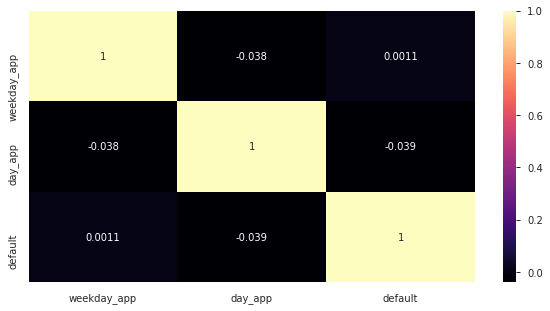

In [14]:
plt.figure(figsize=(10,5))
sns.heatmap(df[['app_date','weekday_app','day_app','default']].corr(), annot=True,cmap = 'magma')


Линейности нет. Выкинем из датасета исходный столбец с датой - взяли из него всю нужную информацию

In [15]:
df = df.drop('app_date',1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 11038 to 60236
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   day_app           110148 non-null  int64  
 2   weekday_app       110148 non-null  int64  
 3   education         110148 non-null  int64  
 4   sex               110148 non-null  object 
 5   age               110148 non-null  int64  
 6   car               110148 non-null  object 
 7   car_type          110148 non-null  object 
 8   decline_app_cnt   110148 non-null  int64  
 9   good_work         110148 non-null  int64  
 10  score_bki         110148 non-null  float64
 11  bki_request_cnt   110148 non-null  int64  
 12  region_rating     110148 non-null  int64  
 13  home_address      110148 non-null  int64  
 14  work_address      110148 non-null  int64  
 15  income            110148 non-null  int64  
 16  sna              

In [17]:
bin_cols = []
cat_cols = []
num_cols = []
for col in df.columns:
    s = df[col].value_counts()
    if len(s)<=2:
        bin_cols.append(col)
    elif(len(s)<=10):
        cat_cols.append(col)
    else:
        num_cols.append(col)
#     display(s)
print('bin_cols',bin_cols)
print('cat_cols',cat_cols)
print('num_cols',num_cols)

# проверим распределение вручную
# display(df)
        
        

bin_cols ['sex', 'car', 'car_type', 'good_work', 'foreign_passport', 'default', 'train']
cat_cols ['weekday_app', 'education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
num_cols ['client_id', 'day_app', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']


**Для упрощения обработки разобьем данные на три типа переменных: числовые, категориальные и бинарные**

In [18]:
# убираем 'default' и 'train'

bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['weekday_app', 'education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['day_app', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']


## Обработа бинарных признаков

In [19]:
# Преобразуем все бинарные признаки в 1 и 0 и посмотрим их важность
label_encoder = LabelEncoder()
for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [20]:
df[bin_cols].head(5)

,sex,car,car_type,good_work,foreign_passport
11038,0,1,0,0,1
25920,0,0,0,0,1
72759,1,0,0,1,0
108665,1,0,0,1,1
31672,1,0,0,0,0


Для анализа связи с default выделим строки из df_train, где default известен

In [21]:
df1 = df[df['train']==1]

Посмотрим, как распределение каждого бинарного признака в зависимости от default

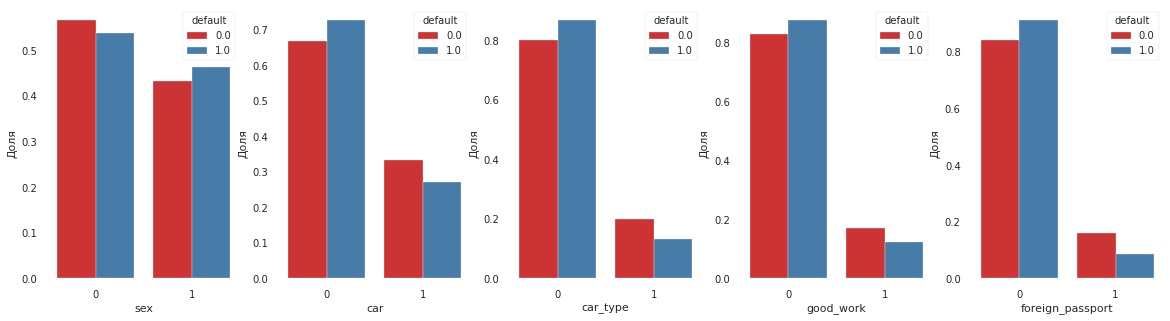

In [22]:
fig, axes = plt.subplots(1, 5, figsize=(20,5))
for column,i in zip (bin_cols,range(5)):
    data = df1[column].groupby(df1["default"]).value_counts(normalize=True).rename("Доля").reset_index()
    sns.barplot(x=column, y="Доля", hue="default", data=data,palette="Set1",ax=axes.flat[i])
   

Проверим значимость категориальных и бинарных переменных

<AxesSubplot:>

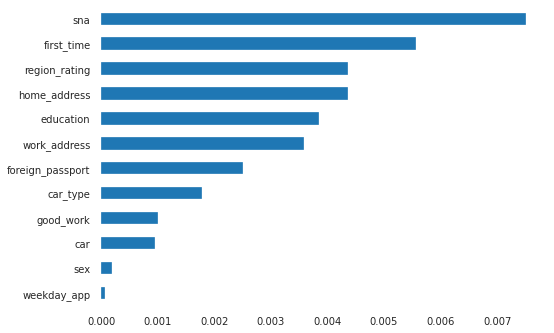

In [23]:
imp_cat = Series(mutual_info_classif(df1[bin_cols + cat_cols], df1['default'], discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

В результате оценки параметров важности можно понять, что новый признак weekday_app имеет некую важность в данном датасете отличную от нуля

**Вывод: 1.очевидно, что люди с плохой работой берут чаще кредиты, а также чаще его не возвращают
2. Неочевидно но факт, женщны чаще берут кредиты
3. Наличие машины скорее всего связано с хорошей работой,так как люди без машины берут чаще кредиты.
4. Аналогично п.3 люди с хорошей работой скорре всего имеют загран паспор**

## Рассмотрим числовые признаки

In [24]:
df1[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 11038 to 60236
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   day_app          73799 non-null  int64  
 1   age              73799 non-null  int64  
 2   decline_app_cnt  73799 non-null  int64  
 3   score_bki        73799 non-null  float64
 4   bki_request_cnt  73799 non-null  int64  
 5   income           73799 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 6.0 MB


<AxesSubplot:>

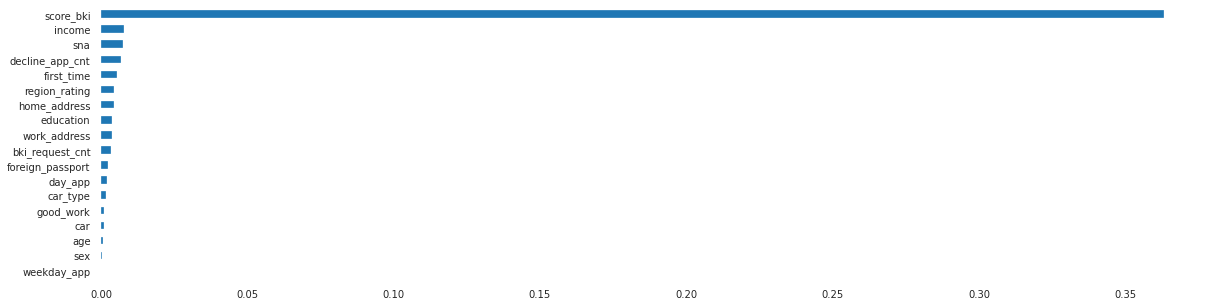

In [25]:
imp_cat = Series(mutual_info_classif(df1[num_cols+bin_cols + cat_cols], df1['default'],
                                     discrete_features =True), index = num_cols+bin_cols + cat_cols)

fig, axes = plt.subplots(1, 1, figsize=(20,5))
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<del>Отметим, что день недели имеет более высокую важност, чем возраст</del>


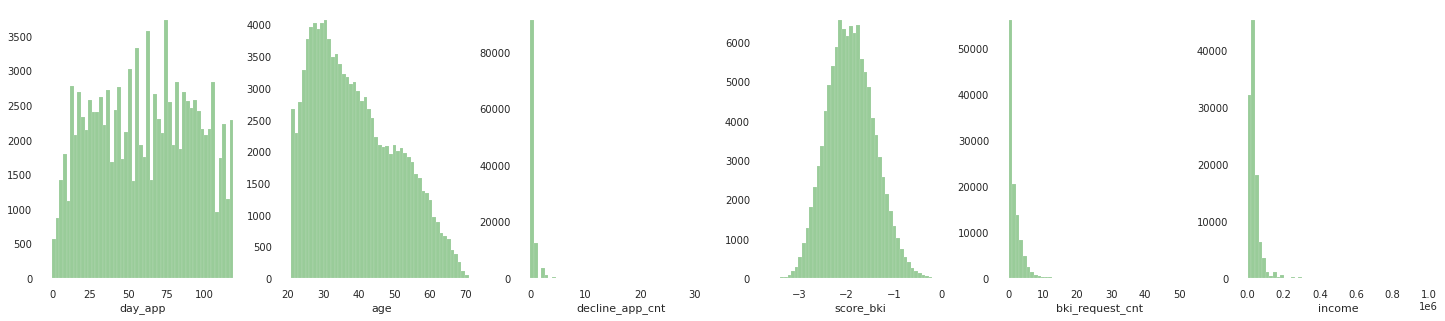

In [26]:
fig, axes = plt.subplots(1, 6, figsize=(25,5))
for i,j in zip (num_cols,range(6)):
    sns.distplot(df[i], kde = False, rug=False,ax=axes.flat[j],color="g")
  

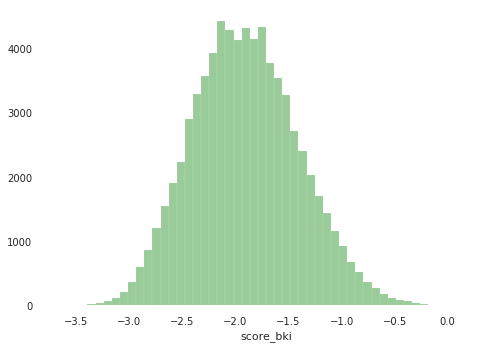

In [27]:
plt.figure()
sns.distplot(df1['score_bki'], kde = False, rug=False,color="g")
plt.show()

**Прологорифмируем смещенные числовые данные, чтобы данные были распределны более нормально и еще раз построим графики**

In [28]:
num_cols_2 = ['age','income']
# df[num_cols_2] =(df[num_cols_2]).transform(np.log)
for i,col in enumerate(num_cols_2):
    df[col] = np.log(df[col] + 1)


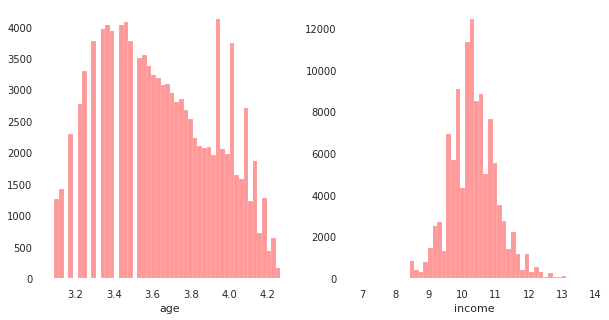

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
for i,j in zip (num_cols_2,range(6)):
    sns.distplot(df[i], kde = False, rug=False,ax=axes.flat[j],color="r")

**Исследование графиков зависимости категориальных признаков от Default не имеет смысла, так как все равно мы не знаем значений каждой категории**

## Оценка корреляции

<AxesSubplot:>

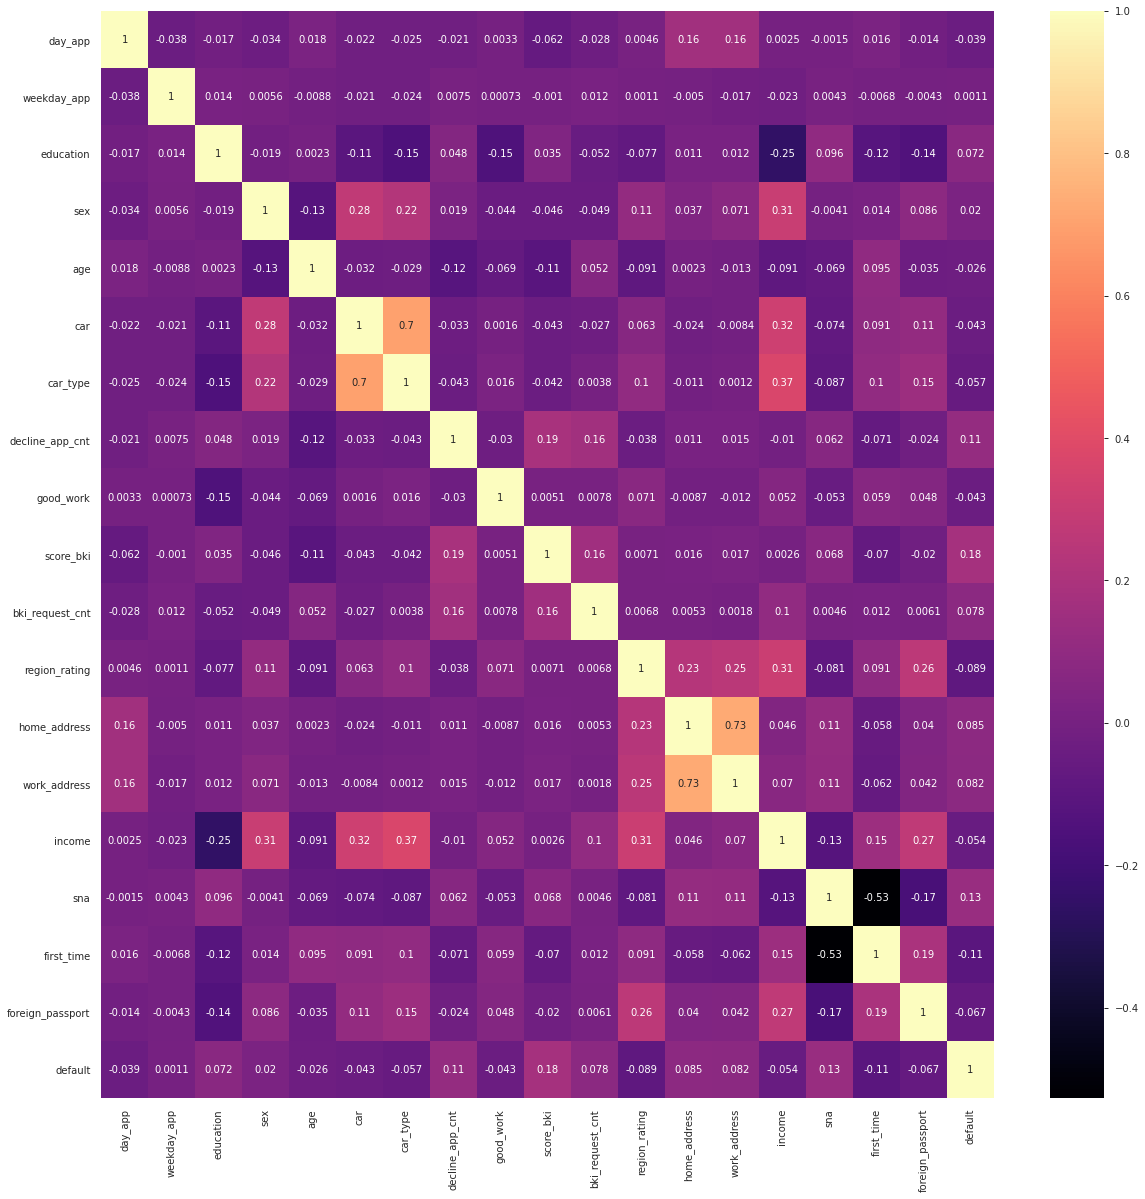

In [30]:
plt.figure(figsize=(20,20)) 
sns.heatmap(df.drop(['client_id', 'train'], axis=1).corr(),annot = True, cmap = 'magma')

Видим пары сильно зависимых признаков:
- car и car_type. В типе машины добавим тип 2 - "нет машины". А наличие машины удалим
- work_address and home_address. Удалим домашний адрес, так как он чуть хуже коррелирует с целевой переменной

In [31]:
df['car_type'] = df[['car','car_type']].apply(lambda x: 2 if x['car']==0 else x['car_type'], axis=1)
df[['car','car_type']]

df.drop('car', axis=1, inplace=True)

In [32]:
df[['work_address','home_address']]
df.drop('home_address', axis=1, inplace=True)

#  Подготовка данных к машинному обучению


<del>Применим One-Hot Encoding для того, чтобы наша модель могла работать с данным, у которох 3 и более категорий</del>


Применим Dumming к категориальным признакам

In [33]:
# x_cat = OneHotEncoder(sparse = False).fit_transform((df[cat_cols].values))
# x_cat.shape
cat_cols = ['weekday_app',
 'education',
 'region_rating',
 'work_address',
'car_type',
 'sna',
 'first_time']

bin_cols = ['sex', 'good_work', 'foreign_passport']
num_cols = ['day_app', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

df = pd.get_dummies(df, columns=cat_cols, dummy_na=False)

In [34]:
df.head(5)

,client_id,day_app,sex,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,...,car_type_1,car_type_2,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
11038,42,0,0,3.871201,0,0,-2.211580,1,10.463132,1,...,0,0,1,0,0,0,0,0,0,1
25920,14,0,0,3.610918,0,0,-2.164185,0,11.407576,1,...,0,1,1,0,0,0,0,0,0,1
72759,56,0,1,3.258097,0,1,-1.629831,5,10.819798,0,...,0,1,1,0,0,0,0,0,1,0
108665,35,0,1,3.583519,0,1,-2.211979,1,10.819798,1,...,0,1,1,0,0,0,0,0,1,0
31672,20,0,1,3.871201,4,0,-2.047099,3,10.308986,0,...,0,1,1,0,0,0,0,1,0,0


## Разделение данных
Выберем для обучения только данные из файла train

In [35]:
train = df[df['train'] == 1].drop(['train','client_id'], axis=1)
# Удалим
# train.drop('client_id',1, inplace=True)
test = df[df['train'] == 0].drop(['train','client_id'], axis=1)

Сначала необходимо разделить данные на тестовые и тренировочные, и уже потом проводить стандартизацию

In [36]:
# X = np.hstack([df[df['train']==1][bin_cols + num_cols].values, x_cat])
# Y = df[df['train']==1]['default'].values

X = train.drop(['default'], axis=1)
Y = train['default']

In [37]:
# Разделим данные для обучения следующим образом:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

Проведем нормализацию наших числовых данных

In [38]:
# num_cols = ['age','decline_app_cnt','income','bki_request_cnt','score_bki','day_app']
scaler = RobustScaler()
# x_num = scaler.fit_transform(df.values)

# scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

## Пробуем обучение

In [39]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

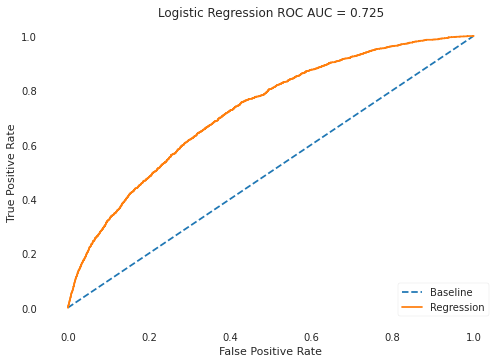

In [40]:
probs = lr.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

accuracy_score 0.8707994579945799
f1_score 0.03832576903681291
precision_score 0.475
precision_score 0.475


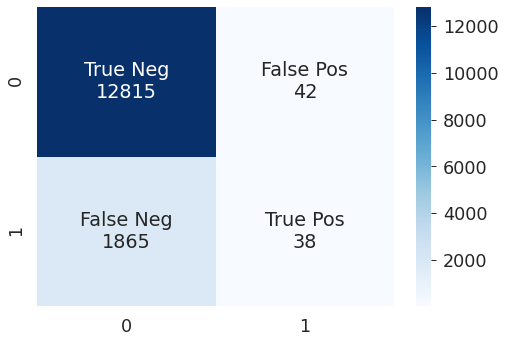

In [41]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

print('accuracy_score', accuracy_score(y_test, y_pred))
print('f1_score', f1_score(y_test, y_pred))
print('precision_score', precision_score(y_test, y_pred))
print('precision_score', precision_score(y_test, y_pred))


Довольно неплохо, попробуем улучшить модель!

# Устранение дисбаланса выборки. Undersampling

Наша выборка не сбалансирована. Посмотрим, что получится, если сбалансировать

In [42]:
Y.value_counts()
# Y[Y == 0]

0.0    64427
1.0     9372
Name: default, dtype: int64

In [43]:
zeros = Y[Y == 0]
ones = Y[Y == 1]
down_index = list(zeros.index[:len(ones)]) + list(ones.index)
X_down = X.loc[down_index, :]
Y_down = Y[down_index]


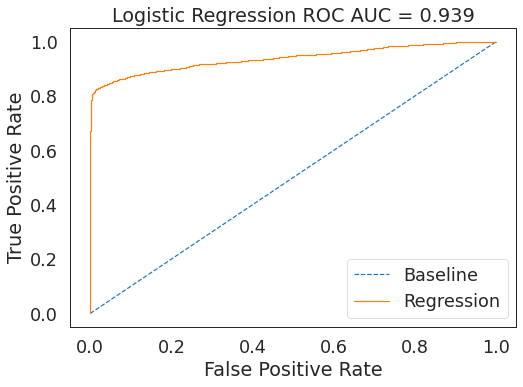

In [44]:

# Разделим данные для обучения следующим образом:
X_train, X_test, y_train, y_test = train_test_split(X_down, Y_down, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# num_cols = ['age','decline_app_cnt','income','bki_request_cnt','score_bki','day_app']
scaler = RobustScaler()
# x_num = scaler.fit_transform(df.values)

# scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

probs = lr.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [45]:
X_down.shape

(18744, 42)

accuracy_score 0.900506801813817
f1_score 0.8937019093758906
precision_score 0.9520340012143291
precision_score 0.9520340012143291


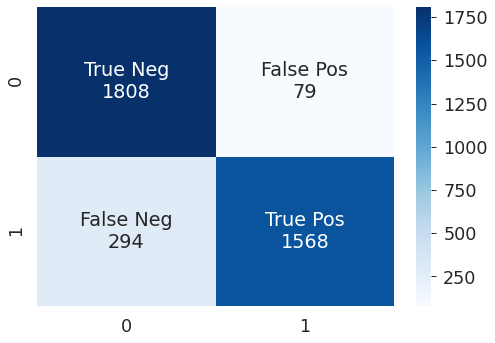

In [46]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

print('accuracy_score', accuracy_score(y_test, y_pred))
print('f1_score', f1_score(y_test, y_pred))
print('precision_score', precision_score(y_test, y_pred))
print('precision_score', precision_score(y_test, y_pred))


# Для удобства обернем модель в класс

In [47]:
# Для упрощения обработки разобьем данные на три типа переменных: числовые, категориальные и бинарные
bin_cols = ['sex', 'good_work', 'foreign_passport']
cat_cols = ['weekday_app', 'education', 'region_rating', 'work_address', 'car_type', 'sna', 'first_time']
num_cols = ['day_app', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

def prepare_data(df_train,df_test):
    
    # объединим их
    df_train['train'] = 1 # пометим тренировочные
    df_test['train'] = 0 # пометим тестовые
    df = pd.concat([df_train, df_test], ignore_index=True)
    
    # обработаем данные
    mode = df['education'].mode().item() # найдем наиболее часто встречающийся вид образования в датасете#
    df['education'] = df['education'].fillna(mode)
    df['education'] = LabelEncoder().fit_transform(df['education'])

    df['app_date'] = pd.to_datetime(df['app_date']) # - преобразуем в нормальный вид столбец с датой подачи
    
    # weekday_app - день недели, в который происходила подачи заявки (0-пн, 1-вт, 2-ср...)
    # day_app - Еще один признак - количество дней с начала записи данных до каждой конкретной подачи
    idx = df.columns.get_loc('app_date') 
    df.insert(loc=idx+1, column='weekday_app', value= df['app_date'].dt.dayofweek)
    df.insert(loc=idx+1, column='day_app', value= (df['app_date'] - df['app_date'].min()).dt.days.astype(int))
    a = [0,1,2,3,4]
    df.insert(loc = idx+1,column='is_workday',value = df['app_date'].dt.weekday.apply(lambda x: 1 if x in a else 0 ))

    df = df.drop('app_date',1)
    
    # car и car_type. В типе машины добавим тип 2 - "нет машины". А наличие машины удалим
    df['car_type'] = df[['car','car_type']].apply(lambda x: 2 if x['car']==0 else x['car_type'], axis=1)
    df.drop('car', axis=1, inplace=True)
    
    # work_address and home_address. Удалим домашний адрес, так как он чуть хуже коррелирует с целевой переменной
    df.drop('home_address', axis=1, inplace=True)
    
    
    # Прологорифмируем смещенные числовые данные, чтобы данные были распределны более нормально
    num_cols_2 = ['age','income']
    for i,col in enumerate(num_cols_2):
        df[col] = np.log(df[col] + 1)
        
        
    # Преобразуем все бинарные признаки в 1 и 0
    label_encoder = LabelEncoder()
    for column in bin_cols:
        df[column] = label_encoder.fit_transform(df[column])
        
    # Преобразуем все категориалные признаки в дамминг-переменные
    df = pd.get_dummies(df, columns=cat_cols, dummy_na=False)        
        
    return df


def devided_data(df):
    train = df.query('train == 1').drop(['train','client_id'], axis=1)
    test = df.query('train == 0').drop(['train'], axis=1)
        
    # Преобразуем все категориалные признаки
#     X_cat = OneHotEncoder(sparse=False).fit_transform(train[cat_cols].values)
#     X_cat = train[cat_cols].values
    # Стандартизация числовых переменных:
#     X_num = StandardScaler().fit_transform(train[num_cols].values)
#     X_num = train[num_cols].values
#     X = np.hstack([X_num, train[num_cols + bin_cols+cat_cols].values, X_cat])
    X = train.drop(['default'],axis=1)
    y = train['default']
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    
    # Подготовим тестовые данные, которые пойдут в сабмит
#     test_X_cat = OneHotEncoder(sparse=False).fit_transform(test[cat_cols].values)
#     test_X_cat = test[cat_cols].values
#     # Стандартизация числовых переменных:
#     test_X_num = StandardScaler().fit_transform(test[num_cols].values)
#     test_data = np.hstack([test_X_num, test[bin_cols].values, test_X_cat])
    test_data = test.drop(['default','client_id'],axis=1)
    return X, y, test_data   

In [48]:
# Разделим данные для обучения следующим образом:


class LogReg():
    def __init__(self, model):
        self.model = model
        
    # Функция обучает модель
    def teach_model(self, X_train, y_train):
        return self.model.fit(X_train, y_train)
         
        
    def get_predict(self, X_test):
        y_pred = self.model.predict(X_test)
        self.y_pred = y_pred
        return y_pred
    
    def get_predict_proba(self, X_test):
        probs = self.model.predict_proba(X_test)[:,1]
        self.probs = probs
        return probs
    
    def show_roc_auc(self, y_test, probs):
        fpr, tpr, threshold = roc_curve(y_test, probs)
        roc_auc = roc_auc_score(y_test, probs)

        plt.figure()
        plt.plot([0, 1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label = 'Regression')
        plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.show()
        
    def show_metrics(self, y_test, y_pred):
        # Визуализация confusion matrix:
        sns.set_context(context='paper', font_scale=2, rc=None)
        group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
        group_counts = ['{0:0.0f}'.format(value) for value in
                        confusion_matrix(y_test, y_pred).flatten()]
        labels = [f'{v1}\n{v2}' for v1, v2 in
                  zip(group_names, group_counts)]
        labels = np.asarray(labels).reshape(2, 2)
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')

        print('accuracy_score', accuracy_score(y_test, y_pred))
        print('f1_score', f1_score(y_test, y_pred))
        print('precision_score', precision_score(y_test, y_pred))
        print('precision_score', precision_score(y_test, y_pred))

## Воспроизведем эксперимент с первой моделью

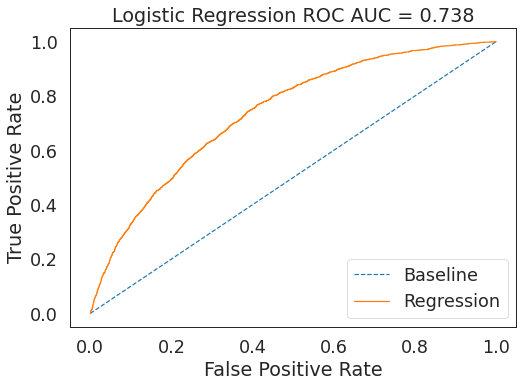

accuracy_score 0.8744579945799458
f1_score 0.0374025974025974
precision_score 0.3673469387755102
precision_score 0.3673469387755102


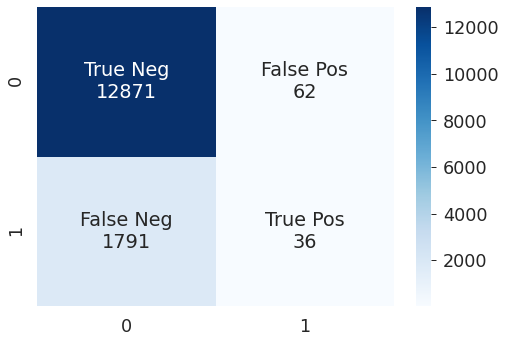

In [49]:
# получаем данные из файла
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
df = prepare_data(df_train,df_test)
X, y, test_data = devided_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

lr = LogReg(LogisticRegression())
model_0 = lr.teach_model(X_train, y_train)
y_pred = lr.get_predict(X_test)

probs = lr.get_predict_proba(X_test)
lr.show_roc_auc(y_test, probs)
lr.show_metrics(y_test, y_pred)


## Воспроизведем эксперимент с балансированной выборкой

### 1. Undersampling

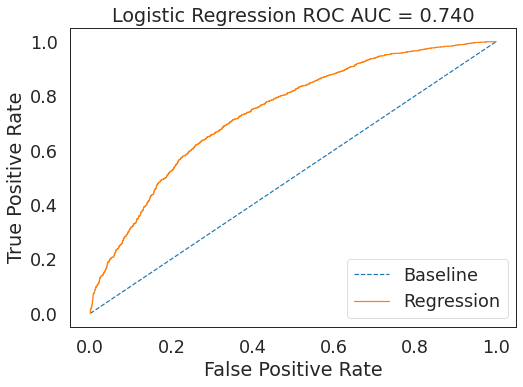

accuracy_score 0.6777807415310749
f1_score 0.6768325307651151
precision_score 0.6743070362473348
precision_score 0.6743070362473348


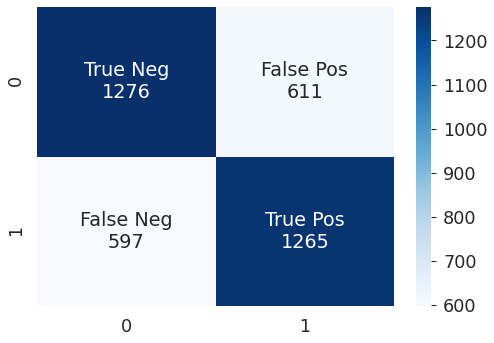

In [50]:

DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'train.csv')
df_test = pd.read_csv(DATA_DIR+'test.csv')
df = prepare_data(df_train,df_test)
X, y, test_data = devided_data(df)

zeros = y[y == 0]
ones = y[y == 1]
down_index = list(zeros.index[:len(ones)]) + list(ones.index)
# default_new = int(len(zeros) / len(ones))
x_down = X.loc[down_index, :]
y_down = y[down_index]

# display(y_down)
X_train, X_test, y_train, y_test = train_test_split(x_down, y_down, test_size=0.2, random_state=42)
# scaler = RobustScaler()
# x_num = scaler.fit_transform(df.values)

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

lr1 = LogReg(LogisticRegression())
model_1 = lr1.teach_model(X_train, y_train)
y_pred = lr1.get_predict(X_test)

probs = lr1.get_predict_proba(X_test)
lr1.show_roc_auc(y_test, probs)
lr1.show_metrics(y_test, y_pred)

(110148, 45)

(18744, 42)

(18744, 42)

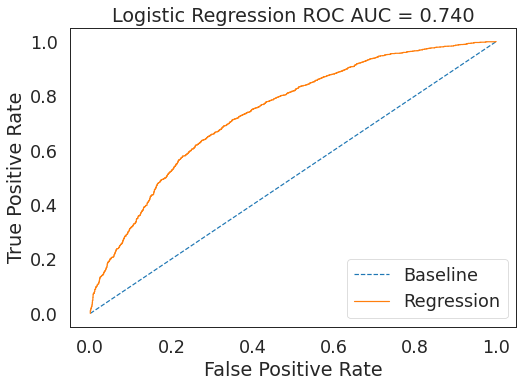

In [51]:
train = df[df['train'] == 1].drop(['train','client_id'], axis=1)
# Удалим
# train.drop('client_id',1, inplace=True)
test = df[df['train'] == 0].drop(['train','client_id'], axis=1)


X = train.drop(['default'], axis=1)
Y = train['default']


scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
# X_test[num_cols] = scaler.transform(X_test[num_cols])

zeros = Y[Y == 0]
ones = Y[Y == 1]
down_index = list(zeros.index[:len(ones)]) + list(ones.index)
X_down = X.loc[down_index, :]
Y_down = Y[down_index]

display(df.shape)
display(x_down.shape)
display(X_down.shape)
np.array_equal(x_down,X_down)
# Разделим данные для обучения следующим образом:
X_train, X_test, y_train, y_test = train_test_split(X_down, Y_down, test_size=0.2, random_state=42)

# num_cols = ['age','decline_app_cnt','income','bki_request_cnt','score_bki','day_app']
# scaler = RobustScaler()
# x_num = scaler.fit_transform(df.values)

model_3 = LogisticRegression(C=7.7826, penalty = 'l2', max_iter = 1000,
                        class_weight='balanced',solver = 'liblinear')
model_3.fit(X_train, y_train)
y_pred = model_3.predict(X_test)

probs = model_3.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Submission

In [52]:
df_test

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,train
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36344,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,0
36345,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,0
36346,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,0
36347,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,0


In [53]:
test = df[df['train'] == 0].drop(['train','client_id','default'], axis=1)
test[num_cols] = scaler.fit_transform(test[num_cols])
y_pred = model_1.predict_proba(test)[:,1]

test['default'] = y_pred
submission = df[df['train'] == 0][['client_id']].merge(test[['default']], left_index=True, right_index=True)
submission

,client_id,default
73799,74835,0.204679
73800,17527,0.854269
73801,75683,0.344853
73802,26883,0.449305
73803,28862,0.155476
...,...,...
110143,83775,0.763154
110144,106254,0.116267
110145,81852,0.823445
110146,1971,0.603842


In [54]:
submission.to_csv('submission.csv', index=False)

In [55]:
import pandas as pd
dd = pd.read_csv('/kaggle/working/submission.csv')
dd[dd.client_id == 110116]


,client_id,default
7587,110116,0.565833
